In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant, calc_Sqw_from_SpinW_results
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

In [3]:
from inxss.experiment import SimulatedExperiment, NeutronExperiment

In [4]:
incident_energy = 260

In [5]:
q_grid = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Qlist_0.csv', delimiter=',')
w_grid_edges = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Elist_0.csv', delimiter=',')
w_grid = (w_grid_edges[1:] + w_grid_edges[:-1]) / 2

Syy = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Syy_withBroadening_0.csv', delimiter=',')
Szz = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Szz_withBroadening_0.csv', delimiter=',')
Sqw = torch.from_numpy(calc_Sqw_from_SpinW_results(q_grid, Syy, Szz))

In [6]:
data = torch.load(f'/pscratch/sd/z/zhantao/inxs_steering_production/experiment_data/summarized_neutron_data_{incident_energy:d}meV.pt')

neutron_exp = NeutronExperiment(tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), data['grid']['w_grid'], data['S'])
hklw_grid = torch.moveaxis(
            torch.stack(torch.meshgrid(neutron_exp.h_grid, neutron_exp.k_grid, neutron_exp.l_grid, neutron_exp.w_grid, indexing='ij'), dim=0), 0, -1)

hklw_grid_norm = hklw_grid[...,:2].norm(dim=-1)
neutron_exp.prepare_experiment(hklw_grid)

In [7]:
model = SpecNeuralRepr.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering_production/models/version_14896845/checkpoints/epoch=7160-step=343728.ckpt'
    ).to(device)

In [8]:
x_input = torch.zeros(hklw_grid.shape[:-1]+(5,))

x_input[...,:3] = hklw_grid[...,[0,1,3]]
x_input[...,3:] = torch.tensor([29.0, 1.68])

s_pred = []
k = 0
with torch.no_grad():
    for _x_input in tqdm(x_input.permute(3,0,1,2,4).reshape((-1, hklw_grid.shape[0], hklw_grid.shape[1], hklw_grid.shape[2], 5,))):
        # print(_x_input.shape)
        _y_output = model(_x_input.to(device), l=hklw_grid[...,k,[2]].to(device)).detach().cpu().numpy()
        s_pred.append(_y_output)
        k += 1
        # break
s_pred = np.moveaxis(np.stack(s_pred), 0, -1)

100%|██████████| 91/91 [00:08<00:00, 10.18it/s]


In [9]:
output_dict = torch.load('paper_preperation/data/bkg_subtraction_output_260meV.pt')

In [10]:
i_inn, j_inn = np.where(output_dict['inn_ddv'] == output_dict['inn_ddv'].min())
i_mid, j_mid = np.where(output_dict['mid_ddv'] == output_dict['mid_ddv'].min())
i_out, j_out = np.where(output_dict['out_ddv'] == output_dict['out_ddv'].min())

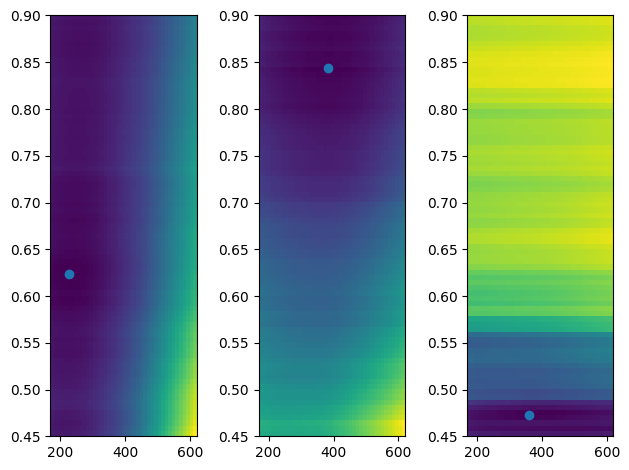

In [11]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(output_dict['inn_ddv'], extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], origin='lower')
ax[0].scatter(output_dict['scales'][j_inn], output_dict['sigmas'][i_inn])
ax[1].imshow(output_dict['mid_ddv'], extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], origin='lower')
ax[1].scatter(output_dict['scales'][j_mid], output_dict['sigmas'][i_mid])
ax[2].imshow(output_dict['out_ddv'], extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], origin='lower')
ax[2].scatter(output_dict['scales'][j_out], output_dict['sigmas'][i_out])
ax[0].set_aspect('auto')
ax[1].set_aspect('auto')
ax[2].set_aspect('auto')
fig.tight_layout()

In [12]:
mask_exp = neutron_exp.Sqw > 1e-10
# mask_pred = (s_pred_sm > 5e-2*s_pred_sm.max()) * mask_exp.cpu().numpy()
# mask_pred = (s_pred > 1e-4*s_pred.max()) * mask_exp.cpu().numpy()

s_pred_masked_sm_inn = gaussian_filter(s_pred, output_dict['sigmas'][i_inn][0]) * mask_exp.numpy()
s_pred_masked_sm_mid = gaussian_filter(s_pred, output_dict['sigmas'][i_mid][0]) * mask_exp.numpy()
s_pred_masked_sm_out = gaussian_filter(s_pred, output_dict['sigmas'][i_out][0]) * mask_exp.numpy()

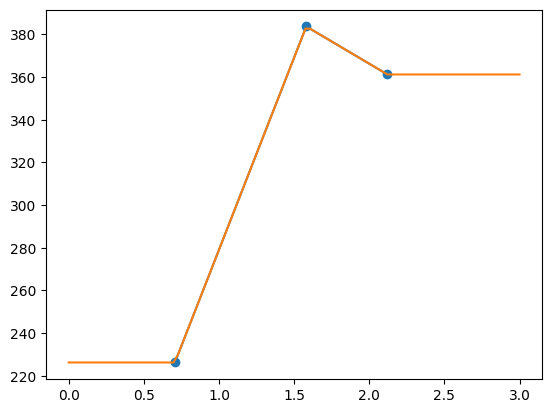

In [13]:
centers = np.array([0.5 * np.sqrt(2), np.sqrt(1.5 ** 2 + 0.5 ** 2), 1.5 * np.sqrt(2)])
scales = np.array([output_dict['scales'][j_inn][0], output_dict['scales'][j_mid][0], output_dict['scales'][j_out][0]])
from scipy.interpolate import CubicSpline

centers_sampled = np.linspace(0, 3, 100)

plt.plot(centers, scales, '-o')
plt.plot(centers_sampled, np.interp(centers_sampled, centers, scales), '-')

In [14]:
interped_scales = np.interp(hklw_grid_norm.numpy(), centers, scales)

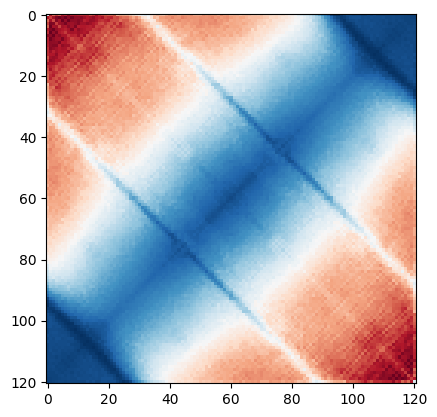

In [15]:

total_signal = neutron_exp.Sqw.cpu().numpy()
background = total_signal.copy()

q_inn_mid = 1.1441
q_mid_out = 1.8512

mask_inn = (hklw_grid_norm <= q_inn_mid).numpy() * mask_exp.numpy()
mask_mid = (hklw_grid_norm >  q_inn_mid).numpy() * (hklw_grid_norm <=  q_mid_out).numpy() * mask_exp.numpy()
mask_out = (hklw_grid_norm >  q_mid_out).numpy() * mask_exp.numpy()

background[mask_inn] = total_signal[mask_inn] - interped_scales[mask_inn] * s_pred_masked_sm_inn[mask_inn]
background[mask_mid] = total_signal[mask_mid] - interped_scales[mask_mid] * s_pred_masked_sm_inn[mask_mid]
background[mask_out] = total_signal[mask_out] - interped_scales[mask_out] * s_pred_masked_sm_inn[mask_out]

plt.imshow(background.sum(-1).sum(-1), cmap='RdBu_r')

In [16]:
data_w_bkg = {key: val for (key, val) in data.items()}
data_w_bkg['background'] = background
data_w_bkg['background_dict'] = output_dict

In [17]:
torch.save(data_w_bkg, f'/pscratch/sd/z/zhantao/inxs_steering_production/experiment_data/summarized_neutron_data_w_bkg_{incident_energy:d}meV_ML.pt')